## Цель 
### Исследовать поведение пользователей, которые зарегистрировались в 2018 году, в обновлённом приложении Quiz Freeze

## Ключевые этапы пути пользователя в приложении:

1. Регистрация 
2. Старт обучения  
3. Завершение обучения 
4. Выбор уровня сложности вопросов 
5. Выбор пакетов вопросов 
6. Покупка платных пакетов вопросов


## Гипотезы
1. Oбучение влияет на скорость прохождения других этапов игры
2. Повторное прохождение обучения положительно влияет на оплату
3. Если пользователь сначала выбирает сложность обучения, то он не будет проходить обучение

## Задачи
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

## Кокретные шаги

1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pur = pd.read_csv("/Users/sascha/Downloads/purchase.csv")

In [3]:
pur['event_datetime'] = pd.to_datetime(pur['event_datetime'])

In [4]:
event = pd.read_csv("/Users/sascha/Downloads/7_4_Events.csv")

In [5]:
event['start_time'] = pd.to_datetime(event['start_time'], errors='coerce')

#### Оставляем в таблице пользователей, которые зарегистрировались в 2018 году 

In [6]:
mask1 = event['start_time'] >= '2018-01-01'
mask2 = event['start_time'] < '2019-01-01'
mask3 = event['event_type'] == 'registration'
user_2018 = event[mask1&mask2&mask3]['user_id'].to_list()
event_df = event[event['user_id'].isin(user_2018)]

In [7]:
joined = event_df.merge(pur, on='user_id', how='left') 
joined.rename(columns = {'id_x':'event_id', 'id_y':'purchase_id'}, inplace = True )

## Гипотеза 1
### Oбучение влияет на скорость прохождения других этапов игры

#### Строим сводную таблицу, где для каждого зарегестрированного игрока в столбцах будет название этапа, а в значениях минимальное время начала этого этапа

In [8]:
min_time = joined.pivot_table(
values='start_time', index='user_id', columns='event_type', aggfunc='min', fill_value=0
).reset_index()

In [9]:
min_time = min_time.merge(pur, on = 'user_id', how='left')
min_time.rename(columns = {'id':'purchase_id', 'event_datetime':'purchase_dt'}, inplace = True )

In [10]:
# меняем формат на датувремя:
min_time['tutorial_start'] = pd.to_datetime(min_time['tutorial_start'], errors='coerce')
min_time['tutorial_finish'] = pd.to_datetime(min_time['tutorial_finish'], errors='coerce')
min_time['level_choice'] = pd.to_datetime(min_time['level_choice'], errors='coerce')
min_time['pack_choice'] = pd.to_datetime(min_time['pack_choice'], errors='coerce')
min_time['purchase_dt'] = pd.to_datetime(min_time['purchase_dt'],errors='coerce') 

In [11]:
# вычисляем время прохождения этапа выбора уровня сложности
min_time['timedelta_level_choice'] = min_time['pack_choice'] - min_time['level_choice']
# вычисляем время прохождения этапа выбора пакета вопросов
min_time['timedelta_pack_choice'] = min_time['purchase_dt'] - min_time['pack_choice']

In [12]:
# менеяем NaT на 0
min_time['tutorial_start'] = pd.to_datetime(min_time['tutorial_start'], errors='coerce').fillna(0)
min_time['tutorial_finish'] = pd.to_datetime(min_time['tutorial_finish'], errors='coerce').fillna(0)
min_time['level_choice'] = pd.to_datetime(min_time['level_choice'], errors='coerce').fillna(0)
min_time['pack_choice'] = pd.to_datetime(min_time['pack_choice'], errors='coerce').fillna(0)
min_time['purchase_id'] = min_time['purchase_id'].fillna(0)
min_time['purchase_dt'] = min_time['purchase_dt'].fillna(0)
min_time['amount'] = min_time['amount'].fillna(0)

In [13]:
min_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19926 entries, 0 to 19925
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   user_id                 19926 non-null  int64          
 1   level_choice            19926 non-null  object         
 2   pack_choice             19926 non-null  object         
 3   registration            19926 non-null  datetime64[ns] 
 4   tutorial_finish         19926 non-null  object         
 5   tutorial_start          19926 non-null  object         
 6   purchase_id             19926 non-null  float64        
 7   purchase_dt             19926 non-null  object         
 8   amount                  19926 non-null  float64        
 9   timedelta_level_choice  5737 non-null   timedelta64[ns]
 10  timedelta_pack_choice   1600 non-null   timedelta64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), timedelta64[ns](2)
memory usage: 1.8+ 

In [14]:
min_time = min_time[['user_id','registration', 'tutorial_start', 'tutorial_finish', 'level_choice', 'pack_choice', 'purchase_id', 'purchase_dt','amount','timedelta_level_choice', 'timedelta_pack_choice']]

#### Проверяем гипотезу о том, что обучение влияет на скорость прохождения других этапов игры

In [15]:
# формируем доп столбцы для следующих признаков: 1. завершил ли пользовательно обучение. 
# 2. начал ли пользователь обучение
# 3. совершил ли пользователь покупку
min_time['tutorial_completed'] = np.where(min_time['tutorial_finish'] == 0, 'no', 'yes')
min_time['tutorial_started'] = np.where(min_time['tutorial_start'] == 0, 'no', 'yes')
min_time['purchase'] = np.where(min_time['purchase_id']==0, 0, 1)

#### Определяю 3 группы: 
1. пользователи, которые завершили обучение
2. пользователи, не начавшие обучение, но не завершившие его
3. пользователи, не начавшие обучение

In [16]:
group_1 = min_time[(min_time['tutorial_completed']=='yes')]
group_2 = min_time[(min_time['tutorial_started']=='yes') & (min_time['tutorial_completed']=='no')]
group_3 = min_time[(min_time['tutorial_started']=='no')]

In [17]:
group_2


,user_id,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase_id,purchase_dt,amount,timedelta_level_choice,timedelta_pack_choice,tutorial_completed,tutorial_started,purchase
8,27840,2018-01-01 20:53:21,2018-01-02 02:07:07,0,2018-01-02 05:18:42,0,0.0,0,0.0,NaT,NaT,no,yes,0
24,27856,2018-01-02 21:18:21,2018-01-03 04:36:55,0,2018-01-03 08:31:35,2018-01-03 08:33:35,0.0,0,0.0,0 days 00:02:00,NaT,no,yes,0
25,27857,2018-01-02 21:25:30,2018-01-03 07:18:57,0,0,0,0.0,0,0.0,NaT,NaT,no,yes,0
27,27859,2018-01-02 21:30:27,2018-01-02 21:37:44,0,2018-01-03 01:11:45,0,0.0,0,0.0,NaT,NaT,no,yes,0
33,27865,2018-01-03 11:14:57,2018-01-03 23:30:17,0,2018-01-04 05:56:32,2018-01-04 06:03:20,16846.0,2018-01-04 14:46:10,250.0,0 days 00:06:48,0 days 08:42:50,no,yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19780,47612,2018-12-27 18:49:35,2018-12-27 22:49:43,0,0,0,0.0,0,0.0,NaT,NaT,no,yes,0
19800,47632,2018-12-28 04:54:41,2018-12-28 09:35:33,0,0,0,0.0,0,0.0,NaT,NaT,no,yes,0
19843,47675,2018-12-28 21:35:31,2018-12-28 23:59:07,0,0,0,0.0,0,0.0,NaT,NaT,no,yes,0
19851,47683,2018-12-29 06:21:41,2018-12-29 16:29:49,0,2018-12-29 19:54:03,0,0.0,0,0.0,NaT,NaT,no,yes,0


In [18]:
group_1['group'] = 'training completed'
group_2['group'] = 'started not completed'
group_3['group'] = 'not started'

/var/folders/vy/dqjs80ms1kg43qy8g1wp0x1m0000gn/T/ipykernel_80837/3823903432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_1['group'] = 'training completed'
/var/folders/vy/dqjs80ms1kg43qy8g1wp0x1m0000gn/T/ipykernel_80837/3823903432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2['group'] = 'started not completed'
/var/folders/vy/dqjs80ms1kg43qy8g1wp0x1m0000gn/T/ipykernel_80837/3823903432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

#### Исследую время прохождения этапа "выбор уровня сложности" для трех групп:

In [19]:
print("Время прохождения этапа выбора уровня у пользователей, которые завершили обучение: {}".format(group_1['timedelta_level_choice'].mean()))
print("... которые начали обучение, но не завершили его: {}".format(group_2['timedelta_level_choice'].mean()))
print("... которые не начали обучение: {}".format(group_3['timedelta_level_choice'].mean()))

Время прохождения этапа выбора уровня у пользователей, которые завершили обучение: 0 days 00:05:18.146058732
... которые начали обучение, но не завершили его: 0 days 00:05:05.295687885
... которые не начали обучение: 0 days 00:05:23.824324324


In [20]:
for_viz = pd.concat([group_1, group_2, group_3], axis=0)

In [21]:
for_viz['timedelta_level_choice'] = for_viz['timedelta_level_choice']/pd.Timedelta(seconds=1)

In [22]:
a = for_viz.groupby(by='group')['timedelta_level_choice'].mean().reset_index()

Text(0.5, 1.0, 'Длительность этапа "выбор уровня вопросов" для 3 групп (в секундах)')

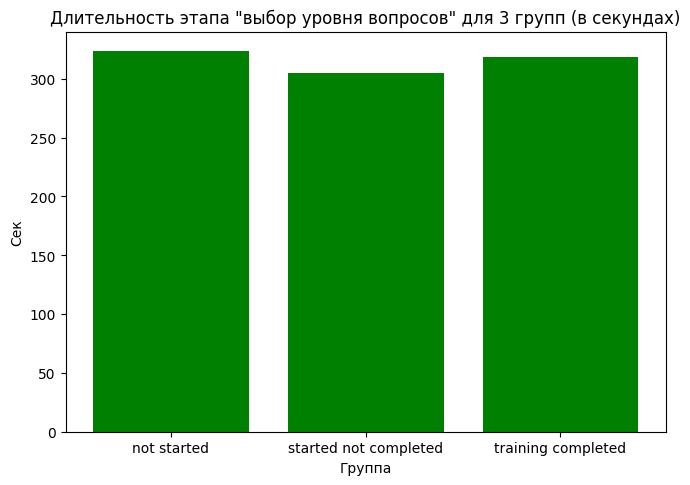

In [23]:
fig = plt.figure(figsize=(6, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = a.group, height = a.timedelta_level_choice, color='green');
main_axes.set_ylabel('Сек')
main_axes.set_xlabel('Группа')
main_axes.set_title('Длительность этапа "выбор уровня вопросов" для 3 групп (в секундах)')

#### Вывод: 
1. Разница между тремя группами на этапе "Выбор уровня" минимальна
#### Исследую время прохождения этапа выбора пакета вопросов у трех групп:

In [24]:
print("Время прохождения этапа выбор пакетов у пользователей, которые завершили обучение: {}".format(group_1['timedelta_pack_choice'].mean()))
print("... которые начали обучение, но не завершили его: {}".format(group_2['timedelta_pack_choice'].mean()))
print("... которые не начали обучение: {}".format(group_3['timedelta_pack_choice'].mean()))

Время прохождения этапа выбор пакетов у пользователей, которые завершили обучение: 3 days 17:17:59.641326883
... которые начали обучение, но не завершили его: 3 days 21:14:46.908396946
... которые не начали обучение: 4 days 04:49:33.590909090


In [25]:
for_viz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19926 entries, 1 to 19925
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   user_id                 19926 non-null  int64          
 1   registration            19926 non-null  datetime64[ns] 
 2   tutorial_start          19926 non-null  object         
 3   tutorial_finish         19926 non-null  object         
 4   level_choice            19926 non-null  object         
 5   pack_choice             19926 non-null  object         
 6   purchase_id             19926 non-null  float64        
 7   purchase_dt             19926 non-null  object         
 8   amount                  19926 non-null  float64        
 9   timedelta_level_choice  5737 non-null   float64        
 10  timedelta_pack_choice   1600 non-null   timedelta64[ns]
 11  tutorial_completed      19926 non-null  object         
 12  tutorial_started        19926 no

In [26]:
for_viz['timedelta_pack_choice'] = for_viz['timedelta_pack_choice']/pd.Timedelta(days=1)

Text(0.5, 1.0, 'Длительность этапа "выбор пакета вопросов" для 3 групп (в днях)')

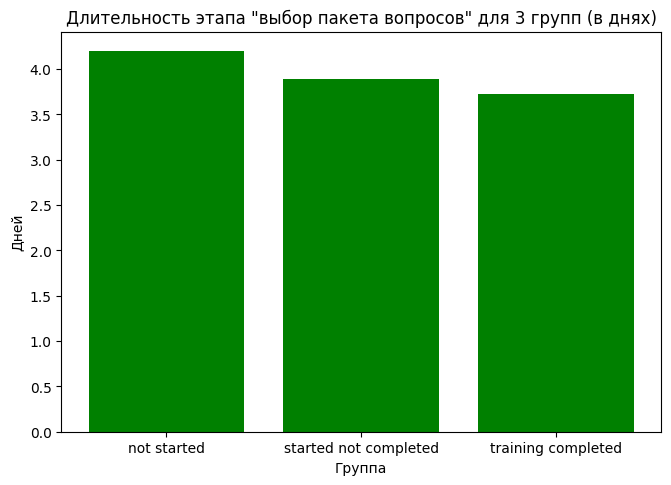

In [27]:
a = for_viz.groupby(by='group')['timedelta_pack_choice'].mean().reset_index()
fig = plt.figure(figsize=(6, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = a.group, height = a.timedelta_pack_choice, color='green');
main_axes.set_ylabel('Дней')
main_axes.set_xlabel('Группа')
main_axes.set_title('Длительность этапа "выбор пакета вопросов" для 3 групп (в днях)')

#### Рассмотрим также процент людей в группах, купивших вопросы

In [28]:
print("Конверсия покупок пользователей, которые завершили обучение: {}%".format(round(group_1.purchase.sum()/group_1.purchase.count()*100,2)))
print("... которые начали обучение, но не завершили его: {}%".format(round(group_2.purchase.sum()/group_2.purchase.count()*100,2)))
print("... которые не начали обучение: {}%".format(round(group_3.purchase.sum()/group_3.purchase.count()*100,2)))

Конверсия покупок пользователей, которые завершили обучение: 14.12%
... которые начали обучение, но не завершили его: 8.15%
... которые не начали обучение: 0.27%


#### Выводы: 
1. разница между тремя группами на этапе "Выбор пакетов" есть. 
2. Пользователи, которые завершили обучение, быстрее всех проходят этап и приступают к оплате. 
3. В среднем на пол часа медленнее к оплате переходят пользователи, начинавшие и не закончившие обучение. 
4. Самой поздней в оплатах является группа, состоящая из пользователей, которые не начали обучение - к оплате переходят в среднем через 4 дня, 4 часа.
5. Конверсия явно различается между группами с завершенным обучением, начинавшей и не закончившей его и группой, не начинавшей обучение: процент людей, сделавших покупку дополнительных карточек в трех группах, равняется соответсвенно 14.12%, 8.15% и 0.27%.  

#### Это свидетельствует о том, что полное прохождение обучения способствует чуть более быстрому (~ 30 мин) прохождению этапа "Выбор пакетов", а также  более вероятной покупке вопросов (в 1.7 раза вероятнее группы, начинавшей, но не закончившей обучение и в 52 раза вероятне группы без обучения). При этом на прохождение этапа "Выбор уровня" прохождение обучения не влияет.

## Гипотеза 2
### Повторное прохождение обучения положительно влияет на оплату


In [29]:
joined = event_df.merge(pur, on='user_id', how='left') 
joined.rename(columns = {'id_x':'event_id', 'id_y':'purchase_id'}, inplace = True )

In [30]:
# добавляем столбец наличия/отсутствия оплат 
joined['purchase'] = np.where(joined['purchase_id'].isnull(), 0,1)

In [31]:
# создаем столбец с количеством начал обучения
tutorial_start = joined[joined['event_type'] == 'tutorial_start'].groupby(by='user_id')['event_type'].count()
tutorial_start = tutorial_start.reset_index()

In [32]:
tutorial_start.rename(columns = {'event_type':'tutorial_start_cnt'}, inplace = True )

In [33]:
# создаем столбец с количеством окончаний обучения
tutorial_finish = joined[joined['event_type'] == 'tutorial_finish'].groupby(by='user_id')['event_type'].count()
tutorial_finish = tutorial_finish.reset_index()

In [34]:
tutorial_finish.rename(columns = {'event_type':'tutorial_finish_cnt'}, inplace = True )

In [35]:
# добавляем столбец с количеством начал обучения
joined = joined.merge(tutorial_start, on = 'user_id', how='left')

In [36]:
# добавляем столбец с количеством окончаний обучения
joined = joined.merge(tutorial_finish, on = 'user_id', how='left')

In [37]:
joined['tutorial_finish_cnt'] = joined['tutorial_finish_cnt']. fillna (0)
joined['tutorial_start_cnt'] = joined['tutorial_start_cnt']. fillna (0)

#### Делим пользователей на 4 группы: 
1. группа пользователей, начавшая обучение 1 раз
2. группа пользователей, начавшая обучение более 1 раза
3. группа пользователей, закончившая обучение 1 раз
4. группа пользователей, закончившая обучение более одного раза

In [38]:
tutorial_start_1 = joined[joined['tutorial_start_cnt'] == 1]
tutorial_start_2 = joined[joined['tutorial_start_cnt'] > 1]
tutorial_finish_1 = joined[joined['tutorial_finish_cnt'] == 1]
tutorial_finish_2 = joined[joined['tutorial_finish_cnt'] > 1]

#### Проверяю, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

In [39]:
print("абсолютное значение оплат у группы пользователей, начавшей обучение 1 раз: {} оплат".format(tutorial_start_1[tutorial_start_1['purchase']==1].purchase.count()))
print("относительное значение: {} %".format(round(tutorial_start_1[tutorial_start_1['purchase']==1].purchase.count()/tutorial_start_1.purchase.count()*100,2)))
      

абсолютное значение оплат у группы пользователей, начавшей обучение 1 раз: 5911 оплат
относительное значение: 16.24 %


In [40]:

print("абсолютное значение оплат у группы пользователей, начавшей обучение более 1 раза: {} оплат".format(tutorial_start_2[tutorial_start_2['purchase']==1].purchase.count()))
print("относительное значение: {} %".format(round(tutorial_start_2[tutorial_start_2['purchase']==1].purchase.count()/tutorial_start_2.purchase.count()*100,2)))
      

абсолютное значение оплат у группы пользователей, начавшей обучение более 1 раза: 3333 оплат
относительное значение: 14.94 %


In [41]:
print("абсолютное значение оплат у группы пользователей, закончившая обучение 1 раз: {} оплат".format(tutorial_finish_1[tutorial_finish_1['purchase']==1].purchase.count()))
print("относительное значение: {} %".format(round(tutorial_finish_1[tutorial_finish_1['purchase']==1].purchase.count()/tutorial_finish_1.purchase.count()*100,2)))
      

абсолютное значение оплат у группы пользователей, закончившая обучение 1 раз: 5785 оплат
относительное значение: 16.73 %


In [42]:
tutorial_finish_2[tutorial_finish_2['purchase']==1].purchase.count()
print("абсолютное значение оплат у группы пользователей, закончившей обучение более 1 раза: {} оплат".format(tutorial_finish_2[tutorial_finish_2['purchase']==1].purchase.count()))
print("относительное значение: {} %".format(round(tutorial_finish_2[tutorial_finish_2['purchase']==1].purchase.count()/tutorial_finish_2.purchase.count()*100,2)))
      

абсолютное значение оплат у группы пользователей, закончившей обучение более 1 раза: 2928 оплат
относительное значение: 14.92 %


### выводы: 
 1. обнаружена разница между количеством оплат у группы, начавшей обучение 1 раз (16.2% оплат), и группы, начавшей обучение более 1 раза (14.9%). Первая в процентном соотношении имеет оплат на 1.3% больше, чем группа с повторными старатами обучения. 
 2. схожая картина наблюлается и в группах с разным количеством завершений обучения. Так в группе с единственным завершением наблюдается процент оплат равняется 16.7%, а в группе с повторными завершениями обучения - 14.9%.
### Проверим, есть ли зависимость доли оплат от количества начала/окончания обучения.


In [43]:
start_pur = joined.groupby(['tutorial_start_cnt', 'purchase']).size ().reset_index(name='purchase_cnt')
start_pur

,tutorial_start_cnt,purchase,purchase_cnt
0,0.0,0,8174
1,0.0,1,66
2,1.0,0,30497
3,1.0,1,5911
4,2.0,0,7834
5,2.0,1,1460
6,3.0,0,2808
7,3.0,1,427
8,4.0,0,1749
9,4.0,1,306


In [44]:
sum_start = start_pur.pivot_table(
values='purchase_cnt', index='tutorial_start_cnt', aggfunc='sum', fill_value=0
)

In [45]:
start_pur = start_pur.merge(sum_start, on='tutorial_start_cnt', how= 'left')

In [46]:
# вычисляем долю покупок (в %) от всех действий пользователй в разрезе количества начал обучения
start_pur = start_pur[start_pur['purchase']==1]
start_pur['percent'] = round(start_pur['purchase_cnt_x']/ start_pur['purchase_cnt_y']*100,2)
start_pur

,tutorial_start_cnt,purchase,purchase_cnt_x,purchase_cnt_y,percent
1,0.0,1,66,8240,0.80
3,1.0,1,5911,36408,16.24
5,2.0,1,1460,9294,15.71
7,3.0,1,427,3235,13.20
9,4.0,1,306,2055,14.89
11,5.0,1,194,1215,15.97
13,6.0,1,196,1507,13.01
15,7.0,1,189,1439,13.13
17,8.0,1,234,1451,16.13
19,9.0,1,327,2115,15.46


Text(0.5, 1.0, 'Доля покупок (в %) в зависимости от числа начала обучения')

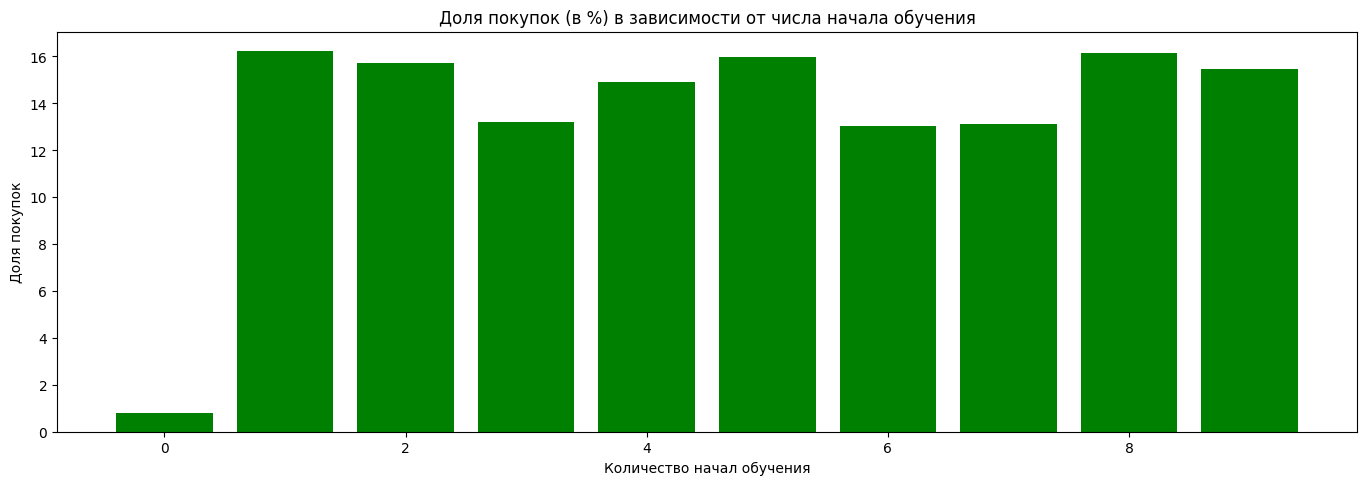

In [47]:
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = start_pur.tutorial_start_cnt, height = start_pur.percent, color='green');
main_axes.set_ylabel('Доля покупок')
main_axes.set_xlabel('Количество начал обучения')
main_axes.set_title('Доля покупок (в %) в зависимости от числа начала обучения')

#### Выводы: 
1. Явной зависимости доли покупок от количества начал обучения не обнаружено. показатель в среднем равен 14.9% ± 2.37%
2. Зато хорошо видно, что отстувие обучения приводит к значительно меньшим покупах: на 14% меньше, чем в группах как минимум с одним началом обучения
#### Проверим таким же образом количество окончаний обучения

In [48]:
finish_purchase = joined.groupby(['tutorial_finish_cnt', 'purchase']).size ().reset_index(name='purchase_cnt')

In [49]:
finish_sum = finish_purchase.pivot_table(
values='purchase_cnt', index='tutorial_finish_cnt', aggfunc='sum', fill_value=0
)

In [50]:
finish_purchase = finish_purchase.merge(finish_sum, on='tutorial_finish_cnt', how= 'left')

In [51]:
finish_purchase = finish_purchase[finish_purchase['purchase']==1]

In [52]:
# создаем столбец процентного значения покупок от всех пользователей группы
finish_purchase ['percent'] = round(finish_purchase['purchase_cnt_x']/finish_purchase['purchase_cnt_y']*100,2)
finish_purchase

,tutorial_finish_cnt,purchase,purchase_cnt_x,purchase_cnt_y,percent
1,0.0,1,597,12741,4.69
3,1.0,1,5785,34588,16.73
5,2.0,1,1301,8431,15.43
7,3.0,1,422,2984,14.14
9,4.0,1,220,1923,11.44
11,5.0,1,267,1583,16.87
13,6.0,1,245,1555,15.76
15,7.0,1,272,1683,16.16
17,8.0,1,117,1024,11.43
19,9.0,1,84,447,18.79


Text(0.5, 1.0, 'Доля покупок (в %) в зависимости от количества завершений обучения')

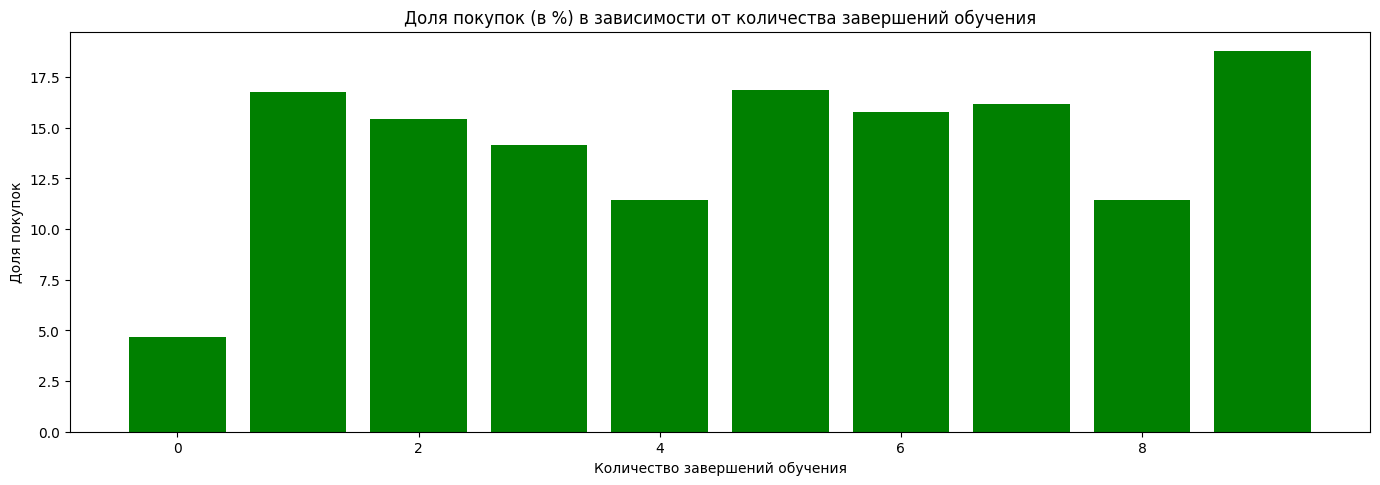

In [53]:
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = finish_purchase.tutorial_finish_cnt, height = finish_purchase.percent, color='green');
main_axes.set_ylabel('Доля покупок')
main_axes.set_xlabel('Количество завершений обучения')
main_axes.set_title('Доля покупок (в %) в зависимости от количества завершений обучения')

#### Выводы: 
1. Явной зависимости доли покупок от количества завершений обучения не обнаружено. показатель в среднем равен 15.2% ± 2.47%
2. Снижение наблюдается к 4 и 8 завершению обучения
3. Также заметна разница между долями в группе с неоконченным обучением и в группе, закончившей обучение хотя бы один раз
#### Интересно посмотреть на то, есть ли разница в покупках между группой, начавшей, но не закончившей обучение и закончившей оба этапа

In [54]:
not_started = joined[joined['tutorial_start_cnt'] == 0]

In [55]:
start_not_finished = joined[(joined['tutorial_finish_cnt'] == 0)&(joined['tutorial_start_cnt'] != 0)]

In [56]:
all_finished = joined[joined['tutorial_finish_cnt'] != 0]

In [57]:
print("абсолютное значение оплат у группы пользователей, не начавшей обучение: {} оплат".format(not_started.purchase.sum()))
print("относительное значение: {} %".format(round(not_started.purchase.sum()/not_started.purchase.count()*100,2)))

print("абсолютное значение оплат у группы пользователей, начавшей, но не закончившей обучение: {} оплат".format(start_not_finished.purchase.sum()))
print("относительное значение: {} %".format(round(start_not_finished.purchase.sum()/start_not_finished.purchase.count()*100,2)))

print("абсолютное значение оплат у группы пользователей, закончившей обучение: {} оплат".format(all_finished.purchase.sum()))
print("относительное значение: {} %".format(round(all_finished.purchase.sum()/all_finished.purchase.count()*100,2)))
      

абсолютное значение оплат у группы пользователей, не начавшей обучение: 66 оплат
относительное значение: 0.8 %
абсолютное значение оплат у группы пользователей, начавшей, но не закончившей обучение: 531 оплат
относительное значение: 11.8 %
абсолютное значение оплат у группы пользователей, закончившей обучение: 8713 оплат
относительное значение: 16.07 %


### выводы: 
1. группа пользователей, не начавшая обучение, реже остальных покупает дополнительные вопросы (конверсия покупок равна всего 0.8% от общего числа пользователей).  
2. группа пользователей, начавшая обучение, но не закончившая его, совершает покупки почти на 5% меньше, чем группа завершившая обучение. Показатели конверсии равны 11.8% и 16.7% соответсвенно. 

# Гипотеза 3
## Если пользователь сначала выбирает сложность обучения, то он не будет проходить обучение

In [58]:
min_time['tutorial_start'] = pd.to_datetime(min_time['tutorial_start'], errors='coerce')
min_time['level_choice'] = pd.to_datetime(min_time['level_choice'], errors='coerce')

In [59]:
min_time['timedelta_start_lvlch'] = min_time['tutorial_start'] - min_time['level_choice']

In [60]:
min_time[min_time['level_choice']< min_time['tutorial_start']]

,user_id,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase_id,purchase_dt,amount,timedelta_level_choice,timedelta_pack_choice,tutorial_completed,tutorial_started,purchase,timedelta_start_lvlch


In [61]:
min_time[min_time['timedelta_start_lvlch'] > pd.Timedelta(0)]

,user_id,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase_id,purchase_dt,amount,timedelta_level_choice,timedelta_pack_choice,tutorial_completed,tutorial_started,purchase,timedelta_start_lvlch


#### Вывод:  
1. Не найдено пользователей, вернувшихся к обучению после выбора уровня сложности, что свидетельствует о прозрачности взаимодействия с игрой. 


### Выводы
#### Гипотеза 1 (Oбучение влияет на скорость прохождения других этапов игры)
Результат: для этапа "Выбор уровня" - нет. Для "Выбор пакетов" - да. 
1. Разница между группами с завершенным обучением, без обчения и с начатым, но не завершенным обучением на этапе "Выбор уровня" минимальна. На 15 мин быстрее переходит к следующему этапу группа, начавшая обучение, но не завершившая его. Разницы между группами без обучения и с обучением практически нет (разница 5 мин в среднем). 

2. Разница между тремя группами на этапе "Выбор пакетов" есть. Пользователи, которые завершили обучение, быстрее всех проходят этап и приступают к оплате (3 дня, 17 часов). В среднем на пол часа медленнее (3 дня, 21 час) к оплате переходят пользователи, начинавшие, но не закочившие обучение. Самой поздней в оплатах является группа, состоящая из пользователей, которые не начали обучение, - в среднем 4 дня, 4 часа.

#### Гипотеза 2 (Повторное прохождение обучения положительно влияет на оплату)
Результат: нет, влияет только факт прохождения обучения, не важно количество прохождений. 
1. Обнаружена разница между количеством оплат у группы, начавшей обучение только 1 раз (конверсия 16.2%), и группы, начавшей обучение более 1 раза (конверсия 14.9%). Первая в процентном соотношении имеет оплат на 1.3% больше, чем группа с повторными старатами обучения.
2. Схожая картина наблюлается и в группах с разным количеством завершений обучения. Так, в группе с единственным завершением наблюдается процент оплат равняется 16.7%, а в группе с повторными завершениями обучения - 14.9%.
3. Зависимость доли оплат от количества начал/окончаний обучения не обнаружена, показатель в среднем равен 14.9% ± 2.37% для начал обучения и 15.2% ± 2.47% для завершений. 
4. Отстувие обучения приводит к значительно меньшим покупах: на 14% меньше, чем в группах как минимум с одним началом обучения, и на 10% меньше, чем в группах, закончивших обучение хотя бы один раз.

#### Гипотеза 3 (Если пользователь сначала выбирает сложность обучения, то он не будет проходить обучение)
Результат: да, пользователи не возвращаются к обучению после выбора уровня сложности. 
1. Не найдено пользователей, вернувшихся к обучению после выбора уровня сложности, что свидетельствует о прозрачности взаимодействия с игрой. 